In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas as gpd
import folium
import warnings
import plotly.express as px

## Termoeléctricas

In [2]:
df_termoelectricas = pd.read_csv("../processed_data/data_termoelectricas.csv", sep = ";")

In [3]:
gdf = gpd.GeoDataFrame(df_termoelectricas, geometry = gpd.points_from_xy(df_termoelectricas["Longitud"], df_termoelectricas["Latitud"]))
gdf.shape

(3858, 13)

Creamos un mapa que tenga como punto de vista inicial Santiago. Luego importamos el polígono de los límites de Chile, el cual graficaremos encima del mapa para resaltarle al usuario el espacio de búsqueda.

In [4]:
f = folium.Figure(width=800, height=600)
map = folium.Map(location = [-33.37041450381538, -70.69793610926665], crs = "EPSG3857" ,zoom_start=3.5, tiles='OpenStreetMap').add_to(f)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
chile = world.loc[world['name'] == 'Chile']
sim_geo = gpd.GeoSeries(chile['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange'})
folium.Popup(chile["name"].values[0]).add_to(geo_j)
geo_j.add_to(map)

A partir de los nombres de las plantas buscamos sus coordenadas y crearemos un nuevo DataFrame que contenga esa información. Luego, graficaremos un marcador en el mapa en esas coordenadas.

In [5]:
plantas = gdf["Planta"].unique() 
puntos = []
for planta in plantas:
    temp_gdf = gdf[gdf["Planta"] == planta]
    coords_planta = temp_gdf.iloc[0]["geometry"]
    puntos.append(coords_planta)
markers = pd.DataFrame({"Planta": plantas, "geometry": puntos})

In [6]:
for _, row in markers.iterrows():
    lat = row["geometry"].y
    lon = row["geometry"].x
    folium.Marker(location=[lat, lon],
                  popup=row["Planta"]).add_to(map)

map

## Sunburst plot

Valores máximos reportados por cada planta y se convierte el GroupBy a DataFrame.

In [7]:
df_termoelectricas_filtrado = df_termoelectricas.groupby(["ANIO","MES","Parametro","CuerpoReceptor","Planta","Tabla","% diferencia_umbral"])["Valor reportado"].max()
df_termoelectricas_filtrado= df_termoelectricas_filtrado.to_frame()
df_termoelectricas_filtrado = df_termoelectricas_filtrado.reset_index()
df_termoelectricas_filtrado.sort_values(by=['ANIO', 'MES',"Parametro","Tabla"])

,ANIO,MES,Parametro,CuerpoReceptor,Planta,Tabla,% diferencia_umbral,Valor reportado
6,2017,1,Cobre,ESTERO LOS GUINDOS,YUNGAY (EX CAMPANARIO),Tabla 1,-99.0,0.010
8,2017,1,Cobre,RIO ACONCAGUA,CENTRAL SAN ISIDRO I,Tabla 1,-97.0,0.030
9,2017,1,Cobre,RIO ACONCAGUA,SAN ISIDRO 2,Tabla 1,-97.0,0.030
0,2017,1,Cobre,BAHIA MEJILLONES,CENTRAL TERMICA ANDINA,Tabla 4,-95.0,0.050
1,2017,1,Cobre,BAHIA MEJILLONES,CENTRAL TERMOELÉCTRICA COCHRANE,Tabla 4,-95.6,0.044
...,...,...,...,...,...,...,...,...
3813,2022,7,Temperatura,BAHÍA CORONEL,COMPLEJO TERMOELECTRICO SANTA MARIA,Tabla 4,-28.3,21.500
3814,2022,7,Temperatura,BAHÍA QUINTERO,CENTRAL TERMOELECTRICA CAMPICHE,Tabla 4,-28.7,21.400
3815,2022,7,Temperatura,BAHÍA QUINTERO,CENTRAL TERMOELÉCTRICA NUEVA VENTANAS,Tabla 4,-36.7,19.000
3816,2022,7,Temperatura,BAHÍA QUINTERO,CENTRAL TERMOELÉCTRICA VENTANAS UNIDADES 1 Y 2,Tabla 4,-24.0,22.800


Seleccionamos sólo los registros donde los valores de los parámetros superen los límites establecidos.

In [8]:
df_termoelectricas_filtrado=df_termoelectricas_filtrado.sort_values(by=['ANIO', 'MES',"Parametro","Tabla"])
df_termoelectricas_filtrado=df_termoelectricas_filtrado[['ANIO','MES',"Parametro","% diferencia_umbral","CuerpoReceptor","Planta","Tabla"]]
df_termoelectricas_filtrado=df_termoelectricas_filtrado[df_termoelectricas_filtrado["% diferencia_umbral"]>0]

Filtraremos sólo por la Tabla 4, correspondiente a descargas (Mar adentro ZPL), puesto que esta es la única que presenta valores que exceden los límites permitidos.

In [9]:
print(df_termoelectricas_filtrado['Tabla'].value_counts())

Tabla 4    18
Name: Tabla, dtype: int64


In [10]:
warnings.filterwarnings("ignore")

df_sunburst = df_termoelectricas_filtrado

df_sunburst=df_sunburst.reset_index()
for i in range(len(df_sunburst)):
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMOELÉCTRICA ","")
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMOELECTRICA ","")
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMICA ","")
    
    title = df_sunburst["Planta"][i].split()
    df_sunburst["Planta"][i]=title[0]+'<BR>'+' '.join(title[1:len(title)])
    
    title = df_sunburst["CuerpoReceptor"][i].split()
    df_sunburst["CuerpoReceptor"][i]=title[0]+'<BR>'+' '.join(title[1:len(title)])

In [11]:
warnings.filterwarnings("ignore")
    
fig = px.sunburst(df_sunburst, path=['ANIO','MES','Parametro','CuerpoReceptor','Planta',"% diferencia_umbral"], 
                  values='% diferencia_umbral',color='Parametro')

fig.update_traces(insidetextfont_color="white",insidetextorientation="radial", selector=dict(type='sunburst'))

fig.update_layout(title_text='CONTAMINANTES QUE SOBEREPASARON LOS LÍMITES PERMITIDOS<BR>ASOCIADOS A LAS DESCARGAS DE RESIDUOS LIQUIDOS A AGUAS MARINAS<BR>VALORES EXPRESADOS EN TERMINOS PORCENTUALES SOBRE EL LIMITE PERMITIDO'
                  , title_x=0.5, title_y=0.98)         
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.add_annotation(x=0.5, y=0.57,
            text="Año",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=18
            )
fig.add_annotation(x=0.5, y=0.62,
            text="Mes",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.72,
            text="Contaminante",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.82,
            text="Cuerpo<BR>Receptor",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.89,
            text="Termoeléctrica",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )
fig.add_annotation(x=0.5, y=0.98,
            text="% Sobre el límite<BR>establecido",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.999, y=0.96,
            text="Molibedeno  ",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=16
            )
fig.add_annotation(x=0.999, y=0.93,
            text="Mercurio      ",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=16
            )
fig.add_annotation(x=0.999, y=0.90,
            text="Temperatura",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=16
            )

fig.add_annotation(x=0.87, y=0.964,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='purple',
            font_size=16
            )
fig.add_annotation(x=0.87, y=0.934,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='green',
            font_size=16
            )
fig.add_annotation(x=0.87, y=0.904,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='red',
            font_size=16
            )

fig.show()

## Temperatura

In [12]:
temperaturas = pd.read_csv("../processed_data/temperatura.csv", sep = ";")
temperaturas_tabla4 = temperaturas[temperaturas["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

In [13]:
fechas = []
for index, row in temperaturas_tabla4.iterrows():
    anio = str(temperaturas_tabla4.iloc[index]["ANIO"])
    if temperaturas_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(temperaturas_tabla4.iloc[index]["MES"])
    else:
        mes = str(temperaturas_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
temperaturas_tabla4["FECHA"] = pd.Series(fechas)
temperaturas_tabla4["FECHA"] = temperaturas_tabla4["FECHA"].astype("datetime64")

In [14]:
temperaturas_tabla4.shape

(783, 14)

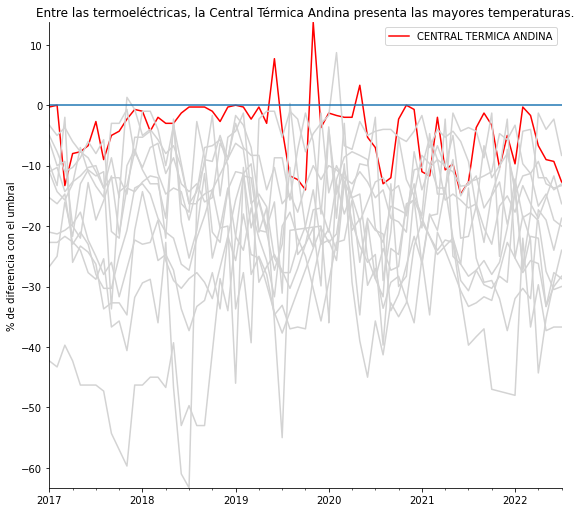

In [15]:
plantas = temperaturas_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = temperaturas_tabla4[temperaturas_tabla4["Planta"] == planta]
    color = 'red' if planta == 'CENTRAL TERMICA ANDINA' else 'lightgray'
    label = planta if planta == 'CENTRAL TERMICA ANDINA' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("Entre las termoeléctricas, la Central Térmica Andina presenta las mayores temperaturas.")
ax.autoscale(enable = True, axis = "both", tight = True)
ax.legend()
plt.show()

## Molibdeno

In [16]:
molibdeno = pd.read_csv("../processed_data/molibdeno.csv", sep = ";")
molibdeno_tabla4 = molibdeno[molibdeno["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

In [17]:
fechas = []
for index, row in molibdeno_tabla4.iterrows():
    anio = str(molibdeno_tabla4.iloc[index]["ANIO"])
    if molibdeno_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(molibdeno_tabla4.iloc[index]["MES"])
    else:
        mes = str(molibdeno_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
molibdeno_tabla4["FECHA"] = pd.Series(fechas)
molibdeno_tabla4["FECHA"] = molibdeno_tabla4["FECHA"].astype("datetime64")

In [18]:
molibdeno_tabla4.shape

(254, 14)

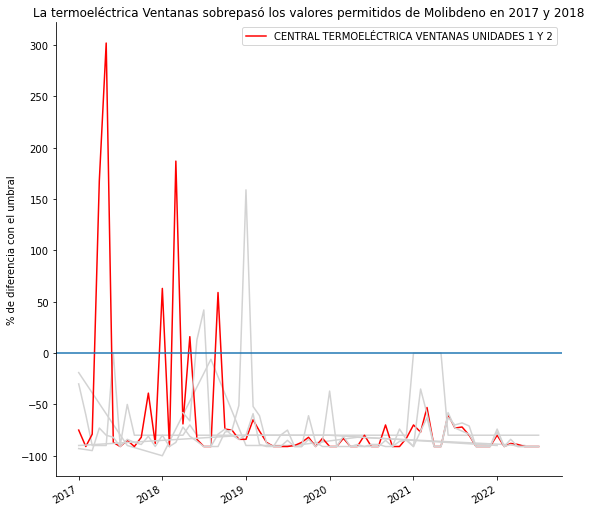

In [19]:
plantas = molibdeno_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = molibdeno_tabla4[molibdeno_tabla4["Planta"] == planta]
    color = 'red' if planta == 'CENTRAL TERMOELÉCTRICA VENTANAS UNIDADES 1 Y 2' else 'lightgray'
    label = planta if planta == 'CENTRAL TERMOELÉCTRICA VENTANAS UNIDADES 1 Y 2' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("La termoeléctrica Ventanas sobrepasó los valores permitidos de Molibdeno en 2017 y 2018")
ax.legend()
plt.show()

## Mercurio

In [20]:
mercurio = pd.read_csv("../processed_data/mercurio.csv", sep = ";")
mercurio_tabla4 = mercurio[mercurio["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

In [21]:
fechas = []
for index, row in mercurio_tabla4.iterrows():
    anio = str(mercurio_tabla4.iloc[index]["ANIO"])
    if mercurio_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(mercurio_tabla4.iloc[index]["MES"])
    else:
        mes = str(mercurio_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
mercurio_tabla4["FECHA"] = pd.Series(fechas)
mercurio_tabla4["FECHA"] = mercurio_tabla4["FECHA"].astype("datetime64")

In [22]:
mercurio_tabla4.shape

(196, 14)

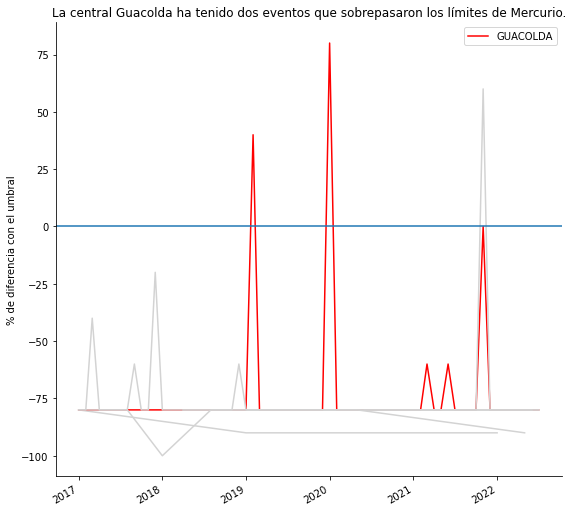

In [23]:
plantas = mercurio_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = mercurio_tabla4[mercurio_tabla4["Planta"] == planta]
    color = 'red' if planta == 'GUACOLDA' else 'lightgray'
    label = planta if planta == 'GUACOLDA' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("La central Guacolda ha tenido dos eventos que sobrepasaron los límites de Mercurio.")
ax.legend()
plt.show()